In [22]:
# Based on https://studywolf.wordpress.com/2020/03/13/converting-your-keras-model-into-a-spiking-neural-network-using-nengo-dl/
# Code contains a lot of repetitions; the goal was to practice rather than optimise.

%matplotlib inline

import matplotlib.pyplot as plt
import nengo
import nengo_dl
import numpy as np
import tensorflow as tf

import utils

In [23]:
params_file_name = "mnist_params"

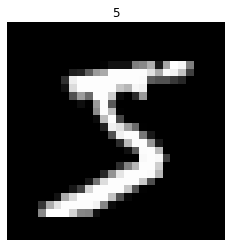

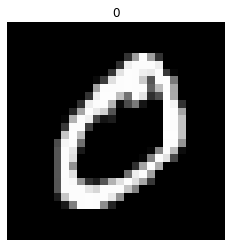

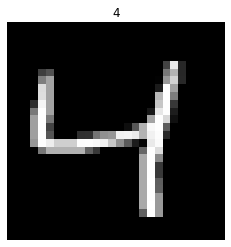

In [24]:
# load MNIST data

minibatch_size = 200
train_images, train_labels, test_images, test_labels = utils.load_mnist(plot=True)



In [25]:
# build a Keras network
tf.random.set_seed(0)

input = tf.keras.Input(shape=(28,28,1))
conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3,activation=tf.nn.relu)(input)
flatten = tf.keras.layers.Flatten()(conv1)
dense1 = tf.keras.layers.Dense(units=10)(flatten)

model = tf.keras.Model(inputs=input, outputs=dense1)

In [26]:
# convert the Keras network to Nengo. The resulting network is ANN not SNN.
converter = nengo_dl.Converter(model, swap_activations={tf.nn.relu: nengo.RectifiedLinear()})
net = converter.net
nengo_input = converter.inputs[input]
nengo_output = converter.outputs[dense1]

In [27]:
# train with NengoDL
with nengo_dl.Simulator(net, seed=0) as sim:
    sim.compile(optimizer=tf.optimizers.RMSprop(0.001),
                loss={nengo_output: tf.losses.SparseCategoricalCrossentropy(from_logits=True)})
    sim.fit(train_images, {nengo_output: train_labels}, epochs=10)
    
    # save parameters to a file
    sim.save_params(params_file_name)

Build finished in 0:00:00                                                      
|#             Optimizing graph: operator simplificaton               | 0:00:00

/Users/katarzynaweronika/opt/anaconda3/envs/nengo_env/lib/python3.10/site-packages/nengo_dl/simulator.py:460: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Epoch 1/10
|             Constructing graph: build stage (0%)             | ETA:  --:--:--

/Users/katarzynaweronika/opt/anaconda3/envs/nengo_env/lib/python3.10/site-packages/nengo_dl/simulator.py:1765: UserWarning: Number of elements (1) in ['ndarray'] does not match number of Nodes (3); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  warnings.warn(


  879/60000 [..............................] - ETA: 5:10 - loss: 5.5682 - probe_loss: 5.5682

KeyboardInterrupt: 

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


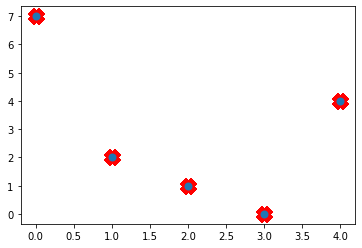

In [28]:
n_test = 5
with nengo_dl.Simulator(net, seed=0) as sim:
    sim.load_params(params_file_name)
    data = sim.predict({nengo_input: test_images[:n_test]})
    
plt.plot(test_labels[:n_test].squeeze(), 'rx', mew=15)
plt.plot(np.argmax(data[nengo_output][:,-1], axis=1), 'o', mew=2)

Build finished in 0:00:00                                                      
Optimizing graph: creating signals finished in 0:00:00                         

/Users/katarzynaweronika/opt/anaconda3/envs/nengo_env/lib/python3.10/site-packages/nengo_dl/simulator.py:460: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


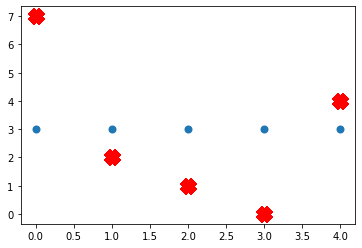

In [29]:
# Convert the ANN to SNN
converter = nengo_dl.Converter(model, swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear()})

net = converter.net
nengo_input = converter.inputs[input]
nengo_output = converter.outputs[dense1]

with nengo_dl.Simulator(net) as sim:
    sim.load_params(params_file_name)
    data = sim.predict({nengo_input: test_images[:n_test]})
    
plt.plot(test_labels[:n_test].squeeze(), 'rx', mew=15)
plt.plot(np.argmax(data[nengo_output][:,-1], axis=1), 'o', mew=2)

In [30]:
# Reinitialise the SNN with probes to examine the activity

converter = nengo_dl.Converter(model, swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear()})
net = converter.net

nengo_input = converter.inputs[input]
nengo_output = converter.outputs[dense1]

# layer we want to probe
nengo_conv1 = converter.layers[conv1]
# probe
with converter.net as net:
    probe_conv1 = nengo.Probe(nengo_conv1, label="probe_conv1")
    
with nengo_dl.Simulator(net) as sim:
    sim.load_params(params_file_name)
    data = sim.predict({nengo_input: test_images[:n_test]})


Build finished in 0:00:00                                                      
|#                Optimizing graph: creating signals                  | 0:00:00

/Users/katarzynaweronika/opt/anaconda3/envs/nengo_env/lib/python3.10/site-packages/nengo_dl/simulator.py:460: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


<AxesSubplot:>

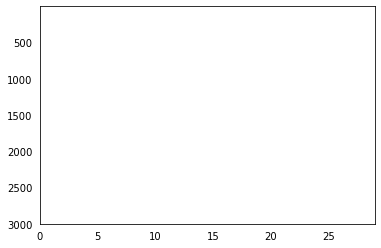

In [34]:
from nengo.utils.matplotlib import rasterplot
# plot spikes for the first image (first batch), for n_neurons, for all time steps
# nengo_dl needs data to be formatted (n_batches, n_timesteps, n_inputs)
n_timesteps = np.shape(test_images[:n_test])[1]
n_neurons_to_plot = 3000
rasterplot(np.arange(n_timesteps), data[probe_conv1][0, :, :n_neurons_to_plot]) 

No spikes were produced by the network.
We can visualise the output of the neurons (that is not spikes).

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Max value:  0.0aph: build stage finished in 0:00:00                            


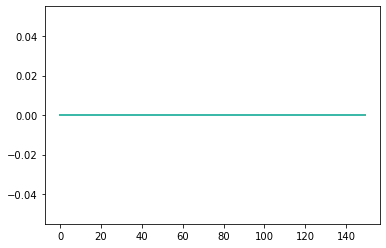

In [36]:
converter = nengo_dl.Converter(
    model,
    swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear()},
)
net = converter.net
 
nengo_input = converter.inputs[input]
nengo_output = converter.outputs[dense1]
nengo_conv1 = converter.layers[conv1]
 
with net:
    probe_conv1 = nengo.Probe(nengo_conv1)
    
with nengo_dl.Simulator(net) as sim:
    sim.load_params("mnist_params")
    data = sim.predict({nengo_input: test_images[:n_test]})

n_neurons_to_plot = 5000
print('Max value: ', np.max(data[probe_conv1].flatten()))
# plot activity of first 5000 neurons, all inputs, all time steps
# we reshape the data so it's (n_batches * n_timesteps, n_neurons)
# for ease of plotting
plt.plot(data[probe_conv1][:, :, :n_neurons_to_plot].reshape(-1, n_neurons_to_plot))
plt.show()

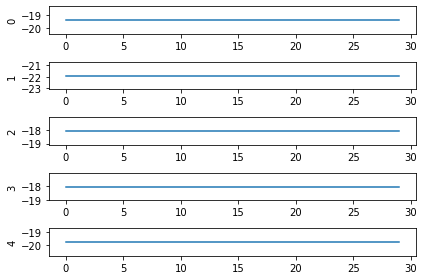

In [38]:
# plot raw network output (the first n dimensions)
n_neurons_to_plot = 5
plt.figure()
for ii in range(n_neurons_to_plot):
    plt.subplot(n_neurons_to_plot, 1, ii+1)
    plt.plot(data[nengo_output][0].reshape(-1, 10)[:, ii])
    plt.ylabel('%i' % ii)
plt.tight_layout()


In [39]:
# increase the duration of input presentation to the network
train_images, train_labels, test_images, test_labels = utils.load_mnist(n_steps=100)


Build finished in 0:00:00                                                      
|#                Optimizing graph: merging operators                 | 0:00:00

/Users/katarzynaweronika/opt/anaconda3/envs/nengo_env/lib/python3.10/site-packages/nengo_dl/simulator.py:460: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Max values:  999.99994ild stage finished in 0:00:00                            


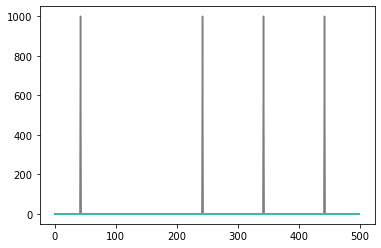

Max value:  1.0
(5, 100, 5000)


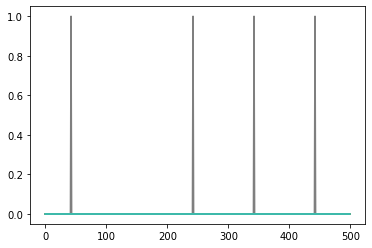

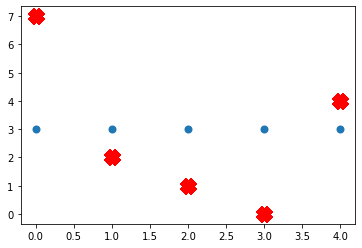

In [40]:
converter = nengo_dl.Converter(model, swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear()})
net = converter.net

nengo_input = converter.inputs[input]
nengo_output = converter.outputs[dense1]
nengo_conv1 = converter.layers[conv1]

with net:
    probe_conv1 = nengo.Probe(nengo_conv1)
    
with nengo_dl.Simulator(net) as sim:
    sim.load_params(params_file_name)
    data = sim.predict({nengo_input: test_images[:n_test]})
    
n_neurons_to_plot = 5000
print('Max values: ', np.max(data[probe_conv1].flatten()))
plt.plot(data[probe_conv1][:, :, :n_neurons_to_plot].reshape(-1, n_neurons_to_plot))
plt.show()

# spikes in Nengo are recorded as 1/dt so that it integrates to 1. We are plotting *dt below for nicer visualisation where y axis corresponds to spike count.
dt = 0.001 # default time step that we did not change
print('Max value: ', np.max(data[probe_conv1].flatten() * dt))
print(data[probe_conv1][:,:,:n_neurons_to_plot].shape)
plt.plot(data[probe_conv1][:, :, :n_neurons_to_plot].reshape(-1, n_neurons_to_plot) * dt)
plt.show()

# predicted vs real labels
plt.plot(test_labels[:n_test].squeeze(), 'rx', mew=15)
plt.plot(np.argmax(data[nengo_output][:,-1], axis=1), 'o', mew=2)
plt.show()

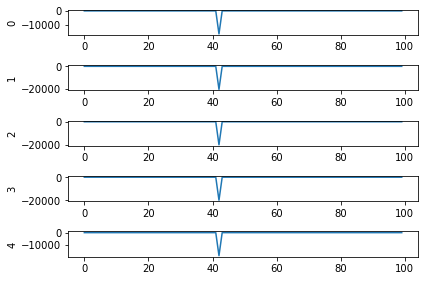

In [41]:
# plot raw network output (the first n dimensions)
n_neurons_to_plot = 5
plt.figure()
for ii in range(n_neurons_to_plot):
    plt.subplot(n_neurons_to_plot, 1, ii+1)
    plt.plot(data[nengo_output][0].reshape(-1, 10)[:, ii])
    plt.ylabel('%i' % ii)
plt.tight_layout()
